## Курсовая
**Требования к курсовому:**

### Ваша задача этом соревновании - предсказать цены на квартиры в датасете test.csv. 
### Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).
    
### Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Нужно будет оформить ноутбук с основными этапами:
1. подготовка данных
    * анализ
    * визуализация
    * обработка выбросов
    * обработка пропусков
    * генерация фичей
2. обучение модели
3. проверка качества модели

Так же надо отправить файл с предсказаниями на kaggle и на private leaderboard получить больше 0.6

Данные для курсового можно брать отсюда https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528 (вкладка data)
________________________
За шаблон оформления курсовой можно взять ноутбук, который будем разбирать на уроке 10: https://www.kaggle.com/julichitai/baseline


*Что обязательно стоит попробовать:*
1. Тщательный анализ данных
2. Поиск странных значений
3. Предобработка данных
4. Генерация разнообразных признаков
5. Разные модели и их разные гиперпараметры

*Что не стоит пробовать:*
1. Кластеризация
2. Модели понижения размерности

#### 1. Загрузка библиотек

In [1]:
# Занрузка библиотек
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [3]:
# Указываем путь к данным
DATASET_PATH_train = 'train.csv'
DATASET_PATH_test = 'test.csv'


### Загрузка данных

#### Описание данных
Id - идентификационный номер квартиры
DistrictId- идентификационный номер района
Rooms - количество комнат
Square - площадь
LifeSquare - жилая площадь
KitchenSquare - площадь кухни
Floor - этаж
HouseFloor - количество этажей в доме
HouseYear - год постройки дома
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
Social_1, Social_2, Social_3 - социальные показатели местности
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
Price - цена квартиры

In [4]:
# Создаем фрем
df_train = pd.read_csv(DATASET_PATH_train)

df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [5]:
df_test = pd.read_csv(DATASET_PATH_test)

df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [6]:
def reduce_mem_usage(df_train):
##""" перебирать все столбцы фрейма данных и изменять тип данных для уменьшения использования памяти  """
    start_mem = df_train.memory_usage().sum() / 1024**2
    print('Объем используемой памяти до оптимизации: {:.2f} MB'.format(start_mem))

    for col in df_train._get_numeric_data().columns:
        col_type = df_train[col].dtype

        c_min = df_train[col].min()
        c_max = df_train[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df_train[col] = df_train[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df_train[col] = df_train[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df_train[col] =df_train[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df_train[col] = df_train[col].astype(np.int64)  
        else:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df_train[col] = df_train[col].astype(np.float32)
            else:
                df_train[col] = df_train[col].astype(np.float64)

    for col in df_train.select_dtypes(include=['object']).columns:
        df_train[col] = df_train[col].astype('category')

    end_mem = df_train.memory_usage().sum() / 1024**2
    print('Объем используемой памяти после оптимизации: {:.2f} MB'.format(end_mem))
    print('Уменьшено на - {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df_train

In [7]:
df_train = reduce_mem_usage(df_train)

Объем используемой памяти до оптимизации: 1.53 MB
Объем используемой памяти после оптимизации: 0.49 MB
Уменьшено на - 68.1%


In [8]:
print('В train строк данных:', df_train.shape)
print('В test строк данных:', df_test.shape)

В train строк данных: (10000, 20)
В test строк данных: (5000, 19)


In [9]:
df_train.shape[1] -1 == df_test.shape[1]

True

### Приведение типов

In [10]:
# Анализируем наличие незаполненных значениях
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

2 признака (LifeSquare -жилая площадь(21%), Healthcare_1 - показатели местности, связанные с охраной здоровья(49%) имеют пропуски данных

In [11]:
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_train = df_train.drop(['Id'], axis = 1)
df_test = df_test.drop(['Id'], axis = 1)

### 1. EDA
Делаем EDA для:

1. Исправления выбросов
2. Заполнения NaN
3. Идей для генерации новых фич

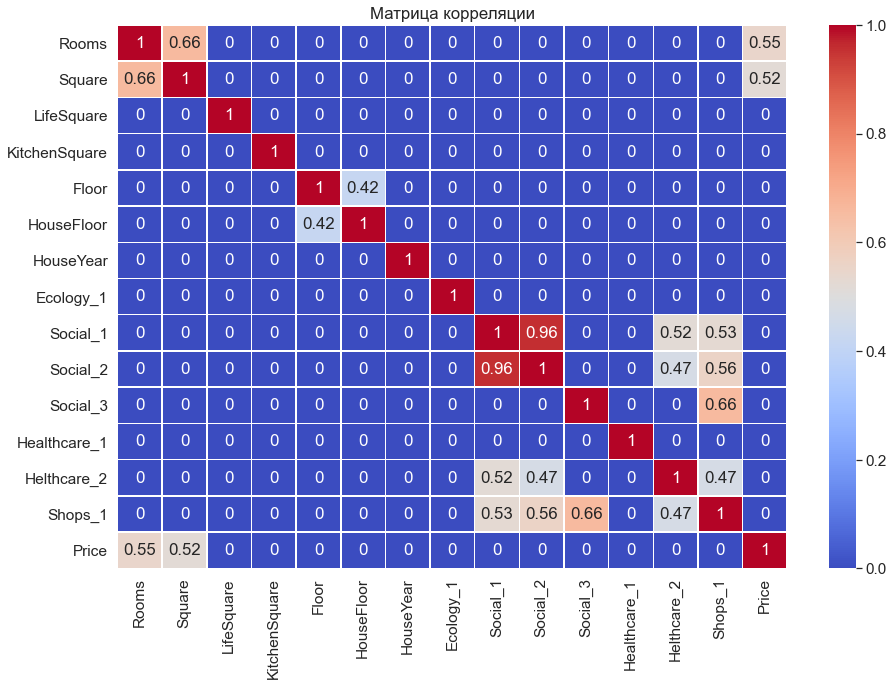

In [12]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляции')
plt.show()

In [13]:
# Корреляция признаков относительно целевой переменной Price
df_train.corr()['Price']

Rooms            0.550291
Square           0.520075
LifeSquare       0.081292
KitchenSquare    0.028864
Floor            0.128715
HouseFloor       0.088280
HouseYear        0.004305
Ecology_1       -0.058381
Social_1         0.263286
Social_2         0.239226
Social_3         0.074878
Healthcare_1     0.138755
Helthcare_2      0.253090
Shops_1          0.180876
Price            1.000000
Name: Price, dtype: float64

Наибольшую корреляцию с целевой переменной имеют следующие признаки:
Rooms            0.550291 - количество комнат
Square           0.520075 - площадь
Floor            0.128715 - этаж
Social_1         0.263286 - социальные показатели местности
Social_2         0.239226 - социальные показатели местности
Healthcare_1     0.138755 - показатели местности, связанные с охраной здоровья
Helthcare_2      0.253090 - показатели местности, связанные с охраной здоровья
Shops_1          0.180876 - показатели, связанные с наличием магазинов, торговых центров

Предварительный анализ, что эти признаки могут существенно влиять на целевую переменную

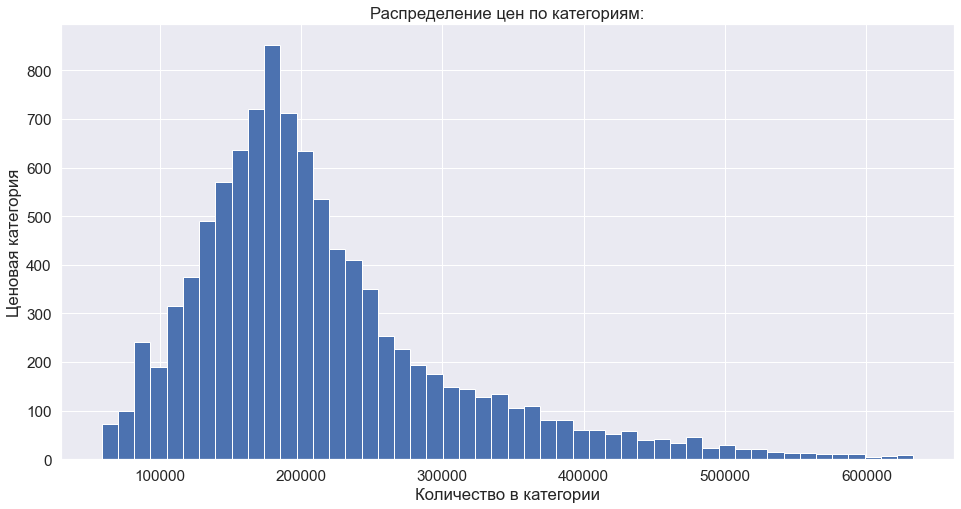

In [14]:
plt.figure(figsize = (16,8))

df_train['Price'].hist(density = False, bins=50)
plt.xlabel('Количество в категории')
plt.ylabel('Ценовая категория')

plt.title('Распределение цен по категориям:')
plt.show()

In [15]:
# Количественные переменные
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [16]:
# Номинативные переменные
df_train.select_dtypes(include=['category', 'object']).columns.tolist()

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

Анализируя среднее, минимальные, максимальные и квантилии видим что не кототые данные имеют выбрасы например:
 - Площадь меньше чем жилая площадь;
 - Количество этажей в доме;
 - Площадь кухни;
 - Количество этажей дома;
 - Маленькоя общая площадь или жилая;
 - Дата постройки дома

In [17]:
# Проведем анализ распределения значений признаков
for col in df_train:
    print('Наименование колонки -'+ str(col)) 
    print(df_train[col].value_counts().sort_values(ascending=False).sort_index(ascending=False))

Наименование колонки -DistrictId
99      97
98      21
97      10
96      71
95      15
      ... 
101     97
100     25
10      56
1      652
0       48
Name: DistrictId, Length: 205, dtype: int64
Наименование колонки -Rooms
19.0       1
10.0       2
6.0        1
5.0       18
4.0      150
3.0     2235
2.0     3880
1.0     3705
0.0        8
Name: Rooms, dtype: int64
Наименование колонки -Square
641.065186    1
604.705994    1
409.425171    1
275.645294    1
212.932358    1
             ..
2.954309      1
2.596351      1
2.377248      1
1.988943      1
1.136859      1
Name: Square, Length: 9995, dtype: int64
Наименование колонки -LifeSquare
7480.592285    1
638.163208     1
461.463623     1
410.639740     1
263.542023     1
              ..
1.049867       1
0.873147       1
0.795539       1
0.641822       1
0.370619       1
Name: LifeSquare, Length: 7886, dtype: int64
Наименование колонки -KitchenSquare
2014.0       1
1970.0       1
123.0        1
112.0        2
96.0         1
84.0     

#### Выполняем приведение даннных  (Исправления выбросов, Заполнения NaN) Square - площадь, LifeSquare - жилая площадь, KitchenSquare - площадь кухни

In [18]:
# Вводим новый признак KitchenSquare_outlier
df_train['KitchenSquare_outlier'] = 0
df_train.loc[(df_train['KitchenSquare'] < 2) | (df_train['KitchenSquare'] > 41), 'KitchenSquare_outlier'] = 1
df_train.loc[(df_train['KitchenSquare'] < 2)  | (df_train['KitchenSquare'] > 40), 'KitchenSquare'] = df_train['KitchenSquare'].median()
#df_train.loc[df_train['KitchenSquare'] < df_train['KitchenSquare'].quantile(0.25), 'KitchenSquare'] = df_train['KitchenSquare'].median()

In [19]:
# Вводим новый признак Square_outlier
df_train['Square_outlier'] = 0
df_train.loc[(df_train['Square'] < 14) | (df_train['Square'] > 301), 'LifeSquare_outlier'] = 1
df_train.loc[(df_train['Square'] < 14) | (df_train['Square'] > 300 ), 'Square'] = df_train['LifeSquare'].median()
#df_train.loc[df_train['Square'] > df_train['Square'].quantile(0.98), 'Square'] = df_train['Square'].median()
#df_train.loc[df_train['Square'] < df_train['Square'].quantile(0.3), 'Square'] = df_train['Square'].median()

In [20]:
# Вводим новый признак LifeSquare_outlier
df_train['LifeSquare_outlier'] = 0
df_train.loc[(df_train['LifeSquare'] < 12) | (df_train['LifeSquare'] > 261), 'LifeSquare_outlier'] = 1
df_train.loc[(df_train['LifeSquare'] < 12) | (df_train['LifeSquare'] > 260 ), 'LifeSquare'] = df_train['LifeSquare'].median()
#df_train.loc[df_train['LifeSquare'] < df_train['LifeSquare'].quantile(0.3), 'LifeSquare'] = df_train['LifeSquare'].median()

In [21]:
# Меняет местами площадь и жилую площадь, если жилая площадь больше чем общая площадь  
df_train['Square'], df_train['LifeSquare'] = np.where(df_train['Square'] < df_train['LifeSquare'],
                                                      (df_train['LifeSquare'],df_train['Square']),
                                                      (df_train['Square'],df_train['LifeSquare']))

In [22]:
# Заполняем незаполненную жилую площадь как разницу между общей площадью и площадью кухни
df_train['LifeSquare'] = df_train['LifeSquare'].fillna(df_train['Square'] - df_train['KitchenSquare'])

#### Выполняем приведение даннных  (Исправления выбросов) Floor - этаж, HouseFloor - количество этажей в доме HouseYear - год постройки дома

In [23]:
# Вводим новый признак HouseFloor_outlier
df_train['HouseFloor_outlier'] = 0
df_train.loc[(df_train['HouseFloor'] < 1) | (df_train['HouseFloor'] > 41), 'HouseFloor_outlier'] = 1
df_train.loc[df_train['HouseFloor'] > 40 , 'HouseFloor'] = df_train['HouseFloor'].median()
df_train.loc[df_train['HouseFloor'] <= df_train['HouseFloor'].min(), 'HouseFloor'] = df_train['Floor'].min()

In [24]:
# Вводим новый признак Floor_outlier
df_train['Floor_outlier'] = 0
df_train.loc[(df_train['Floor'] < 1) | (df_train['Floor'] > 41), 'Floor_outlier'] = 1
df_train.loc[df_train['Floor'] > 40, 'Floor'] = df_train['Floor'].median()
df_train.loc[df_train['Floor'] <= df_train['Floor'].min(), 'Floor'] = df_train['HouseFloor'].min()                                             

In [25]:
# Меняет местами количество этажей и этаж квартиры, если этаж квартиры больше чем количество этажей  
df_train['HouseFloor'], df_train['Floor'] = np.where(df_train['HouseFloor'] < df_train['Floor'],
                                                      (df_train['Floor'],df_train['HouseFloor']),
                                                      (df_train['HouseFloor'],df_train['Floor']))

In [26]:
# Вводим новый признак HouseYear_outlier
current_year = datetime.now().year

df_train['HouseYear_outlier'] = 0
df_train.loc[df_train['HouseYear'] >= current_year, 'HouseYear_outlier'] = 1
df_train.loc[df_train['HouseYear'] >= 20052011, 'HouseYear'] = 2011
df_train.loc[df_train['HouseYear'] >= current_year, 'HouseYear'] = df_train['HouseYear'].median()

#### Выполняем приведение даннных (Исправления выбросов?) Rooms - количество комнат

In [27]:
# Вводим новый признак Rooms_outlier
df_train['Rooms_outlier'] = 0
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] > 6), 'Rooms_outlier'] = 1
df_train.loc[df_train['Rooms'] == 0, 'Rooms'] = 1
df_train.loc[df_train['Rooms'] > 6, 'Rooms'] = df_train['Rooms'].median()

In [28]:
df_train['Healthcare_1'] = df_train['Healthcare_1'].fillna(0)
df_train.loc[df_train['Healthcare_1'] == 0, 'Healthcare_1'] = df_train['Healthcare_1'].median()

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   DistrictId             10000 non-null  object  
 1   Rooms                  10000 non-null  float32 
 2   Square                 10000 non-null  float32 
 3   LifeSquare             10000 non-null  float32 
 4   KitchenSquare          10000 non-null  float32 
 5   Floor                  10000 non-null  float64 
 6   HouseFloor             10000 non-null  float64 
 7   HouseYear              10000 non-null  int32   
 8   Ecology_1              10000 non-null  float32 
 9   Ecology_2              10000 non-null  category
 10  Ecology_3              10000 non-null  category
 11  Social_1               10000 non-null  int8    
 12  Social_2               10000 non-null  int16   
 13  Social_3               10000 non-null  int16   
 14  Healthcare_1           10000 non-null  

In [30]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Helthcare_2,Shops_1,Price,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Rooms_outlier
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.00000,10000.0000,10000.000000,10000.00000
mean,1.888000,56.300743,40.318134,7.373400,7.720200,13.395000,1984.867200,0.118858,24.687000,5352.157400,...,1.319500,4.231300,214139.218750,0.318200,0.0,0.021900,0.02770,0.0001,0.000200,0.00110
std,0.812484,19.115704,18.771997,2.410998,5.247939,5.839451,18.411666,0.119026,17.532614,4006.799803,...,1.493601,4.806341,92872.304688,0.465801,0.0,0.146364,0.16412,0.0100,0.014141,0.03315
min,1.000000,16.698570,11.414181,2.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,59174.777344,0.000000,0.0,0.000000,0.00000,0.0000,0.000000,0.00000
25%,1.000000,41.863287,27.344934,6.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,...,0.000000,1.000000,153872.628906,0.000000,0.0,0.000000,0.00000,0.0000,0.000000,0.00000
50%,2.000000,52.592594,35.463037,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,...,1.000000,3.000000,192269.648438,0.000000,0.0,0.000000,0.00000,0.0000,0.000000,0.00000
75%,2.000000,65.985905,48.648550,9.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,...,2.000000,6.000000,249135.460938,1.000000,0.0,0.000000,0.00000,0.0000,0.000000,0.00000
max,6.000000,275.645294,233.949310,40.000000,37.000000,40.000000,2020.000000,0.521867,74.000000,19083.000000,...,6.000000,23.000000,633233.437500,1.000000,0.0,1.000000,1.00000,1.0000,1.000000,1.00000


In [31]:
# Проверяем наличие NaN для все признаков

for col in df_train:
    print('Наименование колонки -'+ str(col)) 
    print(df_train[col].value_counts(dropna=False))

Наименование колонки -DistrictId
27     851
1      652
23     565
6      511
9      294
      ... 
207      1
209      1
196      1
199      1
205      1
Name: DistrictId, Length: 205, dtype: int64
Наименование колонки -Rooms
2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64
Наименование колонки -Square
32.781261    23
80.794792     2
44.482914     2
65.285133     2
77.703232     2
             ..
99.323555     1
44.661705     1
43.661678     1
84.250710     1
44.000046     1
Name: Square, Length: 9974, dtype: int64
Наименование колонки -LifeSquare
32.781261    213
38.101494      2
33.859653      2
53.043236      2
74.794792      2
            ... 
32.462299      1
58.994247      1
31.332939      1
34.665783      1
34.473602      1
Name: LifeSquare, Length: 9784, dtype: int64
Наименование колонки -KitchenSquare
6.0     4222
8.0     1306
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51

In [32]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.min = None
       # self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.mins = X.min()
      
    def transform(self, X):
        """Трансформация данных"""
    
        # Площадь кухни - KitchenSquare      
        X['KitchenSquare_outlier'] = 0
        X.loc[(X['KitchenSquare'] < 2) | (X['KitchenSquare'] > 41), 'KitchenSquare_outlier'] = 1
        X.loc[(X['KitchenSquare'] < 2) | (X['KitchenSquare'] > 40), 'KitchenSquare'] = self.medians['KitchenSquare']
        #self.medians['KitchenSquare']
              
        # Общая площадь - LifeSquare
        X['Square_outlier'] = 0
        X.loc[(X['Square'] < 14) | (X['Square'] > 301), 'LifeSquare_outlier'] = 1
        X.loc[(X['Square'] < 14) | (X['Square'] > 300 ), 'Square'] = self.medians['LifeSquare']
                
        # Жилая площадь - LifeSquare
        X['LifeSquare_outlier'] = 0
        X.loc[(X['LifeSquare'] < 12) | (X['LifeSquare'] > 261), 'LifeSquare_outlier'] = 1
        X.loc[(X['LifeSquare'] < 12) | (X['LifeSquare'] > 260 ), 'LifeSquare'] = X['LifeSquare']
        
        X['Square'], X['LifeSquare'] = np.where(X['Square'] < X['LifeSquare'],
                                                      (X['LifeSquare'],X['Square']),
                                                      (X['Square'],X['LifeSquare']))
        
        X['LifeSquare'] = X['LifeSquare'].fillna(X['Square'] - X['KitchenSquare'])
        
        
        # Количество этажей - HouseFloor
        X['HouseFloor_outlier'] = 0
        X.loc[(X['HouseFloor'] < 1) | (X['HouseFloor'] > 41), 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] > 40 , 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] <= self.mins['HouseFloor'], 'HouseFloor'] = self.mins['Floor']
        
        # Этаж квартиры - Floor
        X['Floor_outlier'] = 0
        X.loc[(X['Floor'] < 1) | (X['Floor'] > 41), 'Floor_outlier'] = 1
        X.loc[X['Floor'] > 40, 'Floor'] = self.medians['Floor']
        X.loc[X['Floor'] <= self.mins['Floor'], 'Floor'] = self.mins['HouseFloor']          
        
        X['HouseFloor'], X['Floor'] = np.where(X['HouseFloor'] < X['Floor'],
                                                      (X['Floor'],X['HouseFloor']),
                                                      (X['HouseFloor'],X['Floor']))
               
        # Год строительства квартиры - HouseYear
        current_year = datetime.now().year

        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] >= current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] >= 20052011, 'HouseYear'] = 2011
        X.loc[X['HouseYear'] >= current_year, 'HouseYear'] = self.medians['HouseYear']      
                
        # Количество комнат - Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 6), 'Rooms_outlier'] = 1
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']
        
        # Healthcare_1
        X['Healthcare_1'] = X['Healthcare_1'].fillna(0)
        X.loc[X['Healthcare_1'] == 0, 'Healthcare_1'] = self.medians['Healthcare_1']
    
        X.fillna(self.medians, inplace=True)
        X.fillna(self.mins, inplace=True)
        
        return X

In [33]:
for col in df_train.select_dtypes(include=['uint8','uint16', 'float32' ,'float64', 'int64']):
      print(f'Наименование колонки: {col} - {df_train[col].median()} ') 
  

Наименование колонки: Rooms - 2.0 
Наименование колонки: Square - 52.592594146728516 
Наименование колонки: LifeSquare - 35.463035583496094 
Наименование колонки: KitchenSquare - 6.0 
Наименование колонки: Floor - 7.0 
Наименование колонки: HouseFloor - 14.0 
Наименование колонки: Ecology_1 - 0.07542368024587631 
Наименование колонки: Healthcare_1 - 30.0 
Наименование колонки: Price - 192269.65625 
Наименование колонки: KitchenSquare_outlier - 0.0 
Наименование колонки: Square_outlier - 0.0 
Наименование колонки: LifeSquare_outlier - 0.0 
Наименование колонки: HouseFloor_outlier - 0.0 
Наименование колонки: Floor_outlier - 0.0 
Наименование колонки: HouseYear_outlier - 0.0 
Наименование колонки: Rooms_outlier - 0.0 


#### Создаем новые признаки

In [34]:
# бинарные признаки
binary_to_numbers = {'A': 0, 'B': 1}

df_train['Ecology_2'] = df_train['Ecology_2'].replace(binary_to_numbers)
df_train['Ecology_3'] = df_train['Ecology_3'].replace(binary_to_numbers)
df_train['Shops_2'] = df_train['Shops_2'].replace(binary_to_numbers)

### Кодируем размеры района (количество квартир в районе). 

In [35]:
district_size = df_train['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [36]:
# Соединяем размер района с обучающей выборкой по признаку DistrictId
df_train = df_train.merge(district_size, on='DistrictId', how='left')
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,Price,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Rooms_outlier,DistrictSize
0,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,1,...,1,184966.937500,0,0,0,0,0,0,0,22
1,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,1,...,1,300009.437500,0,0,0,0,0,0,0,87
2,53,2.0,44.947952,29.197611,6.0,8.0,12.0,1968,0.049637,1,...,1,220925.906250,1,0,0,0,0,0,0,174
3,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977,0.437885,1,...,1,175616.234375,0,0,0,0,0,0,0,179
4,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,1,...,1,150226.531250,0,0,0,0,0,0,0,97


In [37]:
# Добовляем признак большой район IsDistrictLarge для условия что в районе более 100 квартир
df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > 100).astype(int)

In [38]:
#MedPriceByDistrict
med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [39]:
# Соединяем новый признак DistrictId_Rooms с обучающей выборкой по признаку DistrictId
df_train = df_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df_train.head()


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,KitchenSquare_outlier,Square_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Rooms_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,1,...,0,0,0,0,0,0,0,22,0,207786.125000
1,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,1,...,0,0,0,0,0,0,0,87,0,300009.437500
2,53,2.0,44.947952,29.197611,6.0,8.0,12.0,1968,0.049637,1,...,1,0,0,0,0,0,0,174,1,263206.218750
3,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977,0.437885,1,...,0,0,0,0,0,0,0,179,1,166809.671875
4,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,1,...,0,0,0,0,0,0,0,97,0,158539.062500


In [40]:
# MedPriceByDistrict_2
# med_price_by_district_2 = df_train.groupby(['DistrictId', 'Square'], as_index=False).agg({'Price':'median'})\
#                           .rename(columns={'Price':'MedPriceByDistrict_Sq'})

#med_price_by_district_2.tail()

In [41]:
# Соединяем новый признак DistrictId_Square с обучающей выборкой по признаку DistrictId
#df_train = df_train.merge(med_price_by_district_2, on=['DistrictId', 'Square'], how='left')
#df_train.head()


In [42]:
def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 10, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

def year_to_cat_pandas(X):
    bins = [1000, 1940, 1970, 1990, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [43]:
df_train = year_to_cat_pandas(df_train)
df_train = floor_to_cat_pandas(df_train)
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,Rooms_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969,0.089040,1,...,0,0,0,0,0,22,0,207786.125000,1,2
1,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978,0.000070,1,...,0,0,0,0,0,87,0,300009.437500,2,2
2,53,2.0,44.947952,29.197611,6.0,8.0,12.0,1968,0.049637,1,...,0,0,0,0,0,174,1,263206.218750,1,2
3,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977,0.437885,1,...,0,0,0,0,0,179,1,166809.671875,2,2
4,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976,0.012339,1,...,0,0,0,0,0,97,0,158539.062500,2,3


In [44]:
class FeatureGenetator():
    """Генерация новых признаков"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.district_size = None
        self.med_price_by_district = None
        self.med_price_by_district_2 = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
       
        
    def fit(self, X, y = None):
       # Делаем копию - рекомендация
        X = X.copy()
        
        # Бинарный признак
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        

        # Целевая кодировка
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                           .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        
        ## District, Square
        #df = X.copy()
        
        #if y is not None:
        #    df['Price'] = y.values
            
        #    self.med_price_by_district_2 = df.groupby(['DistrictId', 'Square'], as_index=False).agg({'Price':'median'})\
        #                                     .rename(columns={'Price':'MedPriceByDistrict_Sq'})
        #    
        #    self.med_price_by_district_median_2 = self.med_price_by_district_2['MedPriceByDistrict'].median()

        
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        
    def transform(self, X):
        
        # Binary features
         # self.binary_to_numbers = {'A': 0, 'B': 1}
            
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers) 
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
       # X['new_district'] = 0
       # X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
       # X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
       # if self.med_price_by_district is not None:
      #     X = X.merge(self.med_price_by_district_2, on=['DistrictId', 'Square'], how='left')
       #     X['MedPriceByDistrict'].fillna(self.med_price_by_district_median_2, inplace=True)
            
                        
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 10, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [1000, 1940, 1970, 1990, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        
        return X
            

In [45]:
# Корреляция признаков относительно целевой переменной Price (после обработки признаков)
df_train.corr()['Price']

Rooms                    0.570864
Square                   0.578565
LifeSquare               0.344825
KitchenSquare            0.294527
Floor                    0.109026
HouseFloor               0.114617
HouseYear                0.036650
Ecology_1               -0.058381
Ecology_2                0.022379
Ecology_3               -0.052585
Social_1                 0.263286
Social_2                 0.239226
Social_3                 0.074878
Healthcare_1             0.173266
Helthcare_2              0.253090
Shops_1                  0.180876
Shops_2                  0.070388
Price                    1.000000
KitchenSquare_outlier   -0.216127
Square_outlier                NaN
LifeSquare_outlier      -0.028416
HouseFloor_outlier      -0.014528
Floor_outlier            0.021274
HouseYear_outlier        0.005242
Rooms_outlier           -0.005980
DistrictSize            -0.378619
IsDistrictLarge         -0.337644
MedPriceByDistrict       0.789055
year_cat                 0.035379
floor_cat     

#### Отбор признаков

In [46]:
df_train.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'KitchenSquare_outlier',
 'Square_outlier',
 'LifeSquare_outlier',
 'HouseFloor_outlier',
 'Floor_outlier',
 'HouseYear_outlier',
 'Rooms_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat']

In [47]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['KitchenSquare_outlier', 'LifeSquare_outlier', 'Square_outlier', 'Floor_outlier', 'HouseYear_outlier',
                     'Rooms_outlier', 'DistrictSize', 'IsDistrictLarge', 'MedPriceByDistrict', 'year_cat', 'floor_cat']

target_name = ['Price']

#### Разбиение на train и test

In [48]:
df_train = pd.read_csv(DATASET_PATH_train)
df_test = pd.read_csv(DATASET_PATH_test)

X = df_train.drop(columns = target_name)
y = df_train[target_name]

In [49]:
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [50]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [51]:
X_train, X_valid, y_train, y_valid = train_test_split (X, y, test_size=0.33, shuffle=True, random_state=21)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6700, 19), (3300, 19), (6700, 1), (3300, 1))

In [52]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)


In [53]:

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
df_test = preprocessor.transform(df_test)



In [54]:
X_train.shape, X_valid.shape, df_test.shape

((6700, 26), (3300, 26), (5000, 26))

In [55]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((6700, 32), (3300, 32), (5000, 32))

In [56]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
df_test = df_test[feature_names + new_feature_names]

In [57]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 8)

In [58]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истинные значения')
    plt.title('Прогнозирование Обучающего образца')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('Истинные значения')
    plt.title('Прогнозирование тестового образца')

    plt.show()

#### Построение модели

In [59]:

rf_model = RandomForestRegressor(random_state=21,
                                 criterion='mse',
                                 n_estimators=3000,
                                 min_samples_split=4,
                                 min_samples_leaf=1,
                                 max_features='sqrt',
                                 max_depth=10,
                                 bootstrap=True)



In [60]:

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_estimators=3000, random_state=21)

In [61]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    

In [62]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Train R2:	0.864
Test R2:	0.716


Кросс валидация

In [63]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.74030534, 0.74538887, 0.77106143])

In [64]:
cv_score.mean()

0.7522518782008696

In [65]:
# Важность признаков
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
24,MedPriceByDistrict,2.787975e-01
1,Square,1.926846e-01
0,Rooms,8.708932e-02
2,LifeSquare,7.429084e-02
22,DistrictSize,6.848836e-02
23,IsDistrictLarge,3.723089e-02
11,Social_2,3.717864e-02
3,KitchenSquare,3.533151e-02
10,Social_1,3.491270e-02
12,Social_3,2.853174e-02


8. Прогнозирование на тестовом датасете
Выполнить для тестового датасета те же этапы обработки и постронияния признаков
Не потерять и не перемешать индексы от примеров при построении прогнозов
Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [66]:
df_test.shape

(5000, 27)

In [67]:
df_test

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,LifeSquare_outlier,Square_outlier,Floor_outlier,HouseYear_outlier,Rooms_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,2.0,49.882643,33.432782,6.0,6.0,14.0,1972.0,0.310199,1,1,...,0,0,0,0,0,106.0,1,162550.157311,2,2.0
1,2.0,69.263183,63.263183,6.0,1.0,6.0,1977.0,0.075779,1,1,...,0,0,0,0,0,79.0,0,240307.895031,2,0.0
2,1.0,32.505331,15.948246,12.0,2.0,5.0,1909.0,0.000000,1,1,...,0,0,0,0,0,3.0,0,243028.603096,0,0.0
3,2.0,73.046609,51.940842,9.0,22.0,22.0,2007.0,0.101872,1,1,...,0,0,0,0,0,66.0,0,228796.542555,4,4.0
4,1.0,47.527111,43.387569,6.0,17.0,17.0,2017.0,0.072158,1,1,...,0,0,0,0,0,578.0,1,117801.204933,5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,3.0,67.133911,50.809797,6.0,5.0,9.0,1973.0,0.000170,1,1,...,0,0,0,0,0,88.0,0,246508.486248,2,1.0
4996,1.0,40.198472,21.807061,10.0,12.0,17.0,2017.0,0.007122,1,1,...,0,0,0,0,0,445.0,1,147390.425643,5,3.0
4997,3.0,77.842178,48.282625,9.0,22.0,23.0,1989.0,0.090799,1,1,...,0,0,0,0,0,41.0,0,335781.706862,2,4.0
4998,2.0,81.305222,75.305222,6.0,1.0,4.0,1977.0,0.072158,1,1,...,0,0,0,0,0,153.0,1,180325.766011,2,0.0


In [68]:
DATASET_PATH_submission = 'sample_submission.csv'

In [69]:
submit = pd.read_csv (DATASET_PATH_submission)
submit.head()

,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0


In [77]:
predict_= rf_model.predict(df_test)
predict_

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [78]:
submit['Price'] = predict
submit.head()

NameError: name 'predict' is not defined

In [ ]:
submit.to_csv('rf_submit.csv', index=False)